### Batch Normalization
Build two networks
1. Without batch normalization
2. With batch normalization

Run tests on these two networks.

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
ACTIVATION = tf.nn.relu
N_LAYERS = 7
N_HIDDEN_UNITS = 30

In [5]:
def fix_seed(seed=1):
    # reproducible
    np.random.seed(seed)
    tf.set_random_seed(seed)
    
def plot_his(inputs, inputs_norm):
    # plot histogram for the inputs of every layer
    for j, all_inputs in enumerate([inputs, inputs_norm]):
        for i, input_item in enumerate(all_inputs):
            plt.subplot(2, len(all_inputs), j*len(all_inputs)+(i+1))
            # 清除子图
            plt.cla()
            if(i == 0):
                the_range = (-7, 10)
            else:
                the_range = (-1, 1)
            # ravel()方法会将多为数组降为一维，且返回的是视图（view）会影响原始矩阵
            # hist绘图函数中,bins是直方的宽度
            plt.hist(input_item.ravel(), bins=15, range=the_range, color='#FF5733')
            # xticks, yticks是刻度
            plt.yticks(())
            if(j == 1):
                plt.xticks(the_range)
            else:
                plt.xticks(())
            # gca()获得子图对象
            ax = plt.gca()
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
        plt.title('%s normalizing' %('Without' if j == 0 else 'With'))
    plt.draw()
    # pause后保持绘图而且鼠标可以和图交互（jupyter里不能交互）
    plt.pause(0.01)

In [6]:
def built_net(xs, ys, norm):
    def add_layer(inputs, in_size, out_size, activation_function=None, norm=False):
        # weights and biases (bad initialization for the this case)
        Weights = tf.Variable(tf.random_normal([in_size, out_size], mean=0., stddev=1.))
        biases = tf.Variable(tf.zeros[1, out_size] + 0.1)
        
        # fully connected product
        Wx_plus_b = tf.matmul(inputs, Weights) + biases
        
        # normalize fully connected product
        if norm:
            # Batch Normalize
            # tf.nn.moments 矩
            # 第一个参数是输入的数据，形如[batchsize, height, width, kernels]
            # axes表示在哪个维度上求解，是一个list，例如[0, 1, 2]
            # 返回的mean表示一阶矩，var则是二阶中心矩
            fc_mean, fc_var = tf.nn.moments(Wx_plus_b, axes=[0])
            scale = tf.Variable(tf.ones([out_size]))
            shift = tf.Variable(tf.zeros([out_size]))
            epsilon = 0.001
            
            # apply moving average for mean and var when train on batch
            # 为什么要求滑动平均（moving average）？
            # ExponentialMovingAverage(decay, steps)采用滑动平均的方法更新参数，这个参数初始化需要提供一个衰减速率（decay），用于控制模型的更新速度。这个函数还会维护一个影子变量（也就是更新参数后的参数值），这个影子变量的初始值就是这个变量的初始值
            ema = tf.train.ExponentialMovingAverage(decay=0.5)
            def mean_var_with_update():
                ema_apply_op = ema.apply([fc_mean, fc_var])
                # control_dependencies()设计是用来控制计算流图的，给图中某些计算指定顺序。比如这里的含义是，在执行tf.identity之前，先执行ema_apply_op的内容
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(fc_mean), tf.identity(fc_var)
            mean, var = mean_var_with_update()
            
            Wx_plus_b = tf.nn.batch_normalization(Wx_plus_b, mean, var, shift, scale, epsilon)
            
        # activation
        if(activation_function is None):
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b)
        
        return outputs
    
    fix_seed(1)
    
    if(norm):
        # BN for the first input
        fc_mean, fc_var = tf.nn.moments(xs, axes=[0])
        scale = tf.Variable(tf.ones([1]))
        shift = tf.Variable(tf.zeros([1]))
        epsilon = 0.001
        # apply moving average for mean and var when train on batch
        ema = tf.train.ExponentialMovingAverage(decay=0.5)
        def mean_var_with_update():
            ema_apply_op = ema.apply([fc_mean, fc_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(fc_mean), tf.identity(fc_var)
            mean, var = mean_var_with_update()
            xs = tf.nn.batch_normalization(xs, mean, var, shift, scale, epsilon)
        # record inputs for every layer
        layers_inputs = [xs]
        
        # build hidden layers
        for l_n in range(N_LAYERS):
            layer_input = layers_inputs[l_n]
            in_size = layer_inputs[l_n].get_shape()[1].value
            
            outupt = add_layer(
                layer_input, # input
                in_size, # input size
                N_HIDDEN_UNITS, # output size
                ACTIVATION, # activation function
                norm, # normalize before activation
            )
            layers_inputs.append(output) # add output for next run
            
        # build output layer
        prediction = add_layer(layers_inputs[-1], 30, 1, activation_function=None)
        
        cost = tf.reduce_mean(tf.reduce_sum(tf.square(ys - prediction), reduction_indices=[1]))
        train_op = tf.train.GradientDescentOptimizer(0.001).minimize(cost)
        return [train_op, cost, layers_inputs]

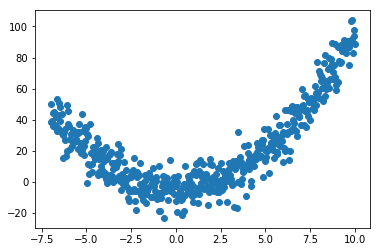

In [8]:
# make up data
fix_seed(1)
x_data = np.linspace(-7, 10, 500)[:, np.newaxis]
np.random.shuffle(x_data)
noise = np.random.normal(0, 8, x_data.shape)
y_data = np.square(x_data) - 5 + noise

# plot input data
plt.scatter(x_data, y_data)
plt.show()

In [9]:
xs = tf.placeholder(tf.float32, [None, 1]) # [num_samples, num_features]
ys = tf.placeholder(tf.float32, [None, 1])

train_op, cost, layers_inputs = built_net(xs, ys, norm=False) # without BN
train_op_norm, cost_norm, layers_input_norm = built_net(xs, ys, norm=True) # with BN

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # record cost
    cost_his = []
    cost_his_norm = []
    record_step = 5
    
    plt.ion()
    plt.figure(figsize=(7, 3))
    for i in range(250):
        if(i % 50 == 0):
            # plot histogram
            all_inputs, all_inputs_norm = sess.run([layers_inputs, layers_input_norm], feed_dict={xs: x_data, ys: y_data})
            plot_his(all_inputs, all_inputs_norm)
        
        # train on batch
        sess.run([train_op, train_op_norm], feed_dict={xs: x_data[i*10:i*10+10], ys: y_data[i*10:i*10+10]})
        
        if(i % record_step == 0):
            # record cost
            cost_his.append(sess.run(cost, feed_dict={xs: x_data, ys: y_data}))
            cost_his_norm.append(sess.run(cost_norm, feed_dict={xs: x_data, y_data}))

    plt.ioff()
    plt.figure()
    plt.plot(np.arange(len(cost_his))*record_step, np.array(cost_his), label='no BN')
    plt.plot(np.arange(len(cost_his))*record_step, np.array(cost_his_norm), label='BN')
    plt.legend()
    plt.show()

SyntaxError: unexpected EOF while parsing (<ipython-input-9-4237342dfef2>, line 20)